Using kernel `conda_pytorch_latest_p36`

# Import

In [1]:
# !pip install transformers
# !pip install datasets

In [2]:
import sys
sys.path.append('../../../')

In [3]:
from pathlib import Path
import os
import random
import pickle
import tarfile
from typing import List
from dataclasses import dataclass

In [108]:
import pandas as pd
import numpy as np
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast, Trainer, TrainingArguments
from sklearn.metrics import classification_report, precision_recall_fscore_support, precision_score, f1_score, recall_score, multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import boto3
from langdetect import detect

In [5]:
from deep.constants import *

# Fastai

In [66]:
def preprocessing(df):
    df = df.copy()
    df['sectors'] = df['sectors'].apply(eval)    
    df['pillars'] = df['pillars'].apply(eval)
    df['pillars'] = df['pillars'].apply(lambda x: list(set(x)))
    df['subpillars'] = df['subpillars'].apply(eval)
    return df

def process_multiclass(df, train, column='pillars', classes=PILLARS):
    relevant_train = df.copy()
    relevant_train = relevant_train[relevant_train[column].apply(len) > 0]
    relevant_train[label_column] = relevant_train.pillars + relevant_train.subpillars
    relevant_train[label_column] = relevant_train[label_column].apply(lambda x: ';'.join(x))
    
    relevant_train['is_valid'] = False if train else True
    
    return relevant_train
    

train = preprocessing(pd.read_csv(LATEST_DATA_PATH / 'data_v0.4.3_train.csv'))
val = preprocessing(pd.read_csv(LATEST_DATA_PATH / 'data_v0.4.3_val.csv'))
test = preprocessing(pd.read_csv(LATEST_DATA_PATH / 'data_v0.4.3_test.csv'))

column = 'subpillars'
classes=SUBPILLARS
text_column = 'excerpt'
label_column = 'merged'
train_df = process_multiclass(train, True, column=column, classes=classes)
test_df = process_multiclass(test, False, column=column, classes=classes)
df = pd.concat([train_df, test_df])

In [107]:
test_df

,entry_id,lead_id,project_id,project_title,analysis_framework_id,excerpt,dropped_excerpt,created_by_id,modified_by_id,verified,verification_last_changed_by_id,sectors,pillars,subpillars,merged,is_valid
0,163665,35315,2028,IMMAP/DFS Syria,1306,"What this means is that families across the country can no longer afford the very basics. And food security and nutrition indicators clearly reflect that. Some 9.3 million people are food insecure. More than 2 million more are at risk of becoming food insecure. 86 per cent of households say they are buying lower quality food, or less food, or skipping meals.",NaN,2232,2232,False,NaN,"[Food Security, Cross]","[Humanitarian Conditions, People At Risk]","[Humanitarian Conditions->Coping Mechanisms, People At Risk->Risk And Vulnerabilities, Humanitarian Conditions->Living Standards, Humanitarian Conditions->Physical And Mental Well Being]",Humanitarian Conditions;People At Risk;Humanitarian Conditions->Coping Mechanisms;People At Risk->Risk And Vulnerabilities;Humanitarian Conditions->Living Standards;Humanitarian Conditions->Physical And Mental Well Being,True
1,162814,37820,2098,IMMAP/DFS Bangladesh,1306,"Dispatch and Referral Unit (DRU): IOM continues to coordinate an expanded fleet of 22 vehicles, 11 of which are supplied by IOM and staffed with drivers fully trained on Infection Prevention and Control.",NaN,657,2233,False,NaN,[Logistics],[Capacities & Response],[Capacities & Response->International Response],Capacities & Response;Capacities & Response->International Response,True
2,163668,35315,2028,IMMAP/DFS Syria,1306,"A third of school-aged children in Syria – 2.5 million children – are out of school. Another 1.6 million are at risk of dropping out of school. The number of out-of-school children has increased by 16 per cent since last year. With school closures due to COVID-19, that number is very likely to increase further",NaN,2232,2232,False,NaN,[Education],"[Humanitarian Conditions, Impact]","[Impact->Driver/Aggravating Factors, Humanitarian Conditions->Living Standards, Impact->Impact On Systems And Services]",Humanitarian Conditions;Impact;Impact->Driver/Aggravating Factors;Humanitarian Conditions->Living Standards;Impact->Impact On Systems And Services,True
3,163115,37820,2098,IMMAP/DFS Bangladesh,1306,"The RIRT coordination system has been formalized and each camp now has RIRT team composed of an isolation unit focal point, contact tracing supervisor and a SM focal. To operationalize engagement of these teams, the World Health organization established WhatsApp groups for a better coordinated COVID-19 response. On 18 July, the camp 22 RIRT team responded to its first confirmed COVID -19 patient. The team assisted the affected family by supporting the patient’s transfer to a SARI ITC. The team also supported as the four family members were transferred to Kerantoli Quarantine Centre in Teknaf.",NaN,2233,2233,False,NaN,[Health],[Capacities & Response],[Capacities & Response->International Response],Capacities & Response;Capacities & Response->International Response,True
4,163030,37820,2098,IMMAP/DFS Bangladesh,1306,"Project implementation partners continued dissemination of messages on prevention of COVID-19 transmission, food safety, waste management, and hygienic practices in advance of EID al – Adha, following IOM WASH unit guidance. The partner organization conducted a total of 153, 674 household sessions reaching 200, 328 beneficiaries an average of three times in the reporting period>> IOM’s implementing partners also conducted 4,410 megaphone messaging session, reaching an estimated 151,475 beneficiaries and average of two times each. Ips additionally coordinated with Camps-in -charge (CiC), si...",NaN,2233,2233,False,NaN,"[Food Security, Health, Cross]",[Capacities & Response],"[Capacities & Response->Number Of People Reached, Capacities & Response->International Response]",Capacities & Response;Capacities & Response->Number Of People Reached;Capacities & Response->Intern

In [6]:
TMP_DIR = Path('./remote-jobs')
MERGED_PATH = Path('models/pytorch-training-2021-06-03-15-28-53-523-fastai-merged/output/output.tar.gz')
SUBPILLAR_PATH = Path('models/pytorch-training-2021-06-03-16-44-29-318-fastai-subpillar/output/output.tar.gz')
EPOCHS5_PATH = Path('models/pytorch-2021-06-03-17-24-17-144-fastai-5ep-merged/output/output.tar.gz')
RESAMPLED5_PATH = Path('models/pytorch-2021-06-03-17-47-47-773-fastai-5ep-resampled/output/output.tar.gz')

In [7]:
def download_locally(remote_path):
    local_file = TMP_DIR / remote_path
    local_file.parent.mkdir(exist_ok=True, parents=True)
    s3 = boto3.client('s3')
    s3.download_file(DEV_BUCKET.name, str(remote_path), str(local_file))
    with tarfile.open(local_file) as f:
        f.extractall(local_file.parent)
    print(local_file.parent)
    return local_file.parent

In [8]:
merged_path = download_locally(MERGED_PATH)
subpillar_path = download_locally(SUBPILLAR_PATH)
epochs5_path = download_locally(EPOCHS5_PATH)
resampled5_path = download_locally(RESAMPLED5_PATH)

remote-jobs/models/pytorch-training-2021-06-03-15-28-53-523-fastai-merged/output
remote-jobs/models/pytorch-training-2021-06-03-16-44-29-318-fastai-subpillar/output
remote-jobs/models/pytorch-2021-06-03-17-24-17-144-fastai-5ep-merged/output
remote-jobs/models/pytorch-2021-06-03-17-47-47-773-fastai-5ep-resampled/output


In [31]:
@dataclass
class FastaiResults:
    classes: List
    train_preds: pd.DataFrame
    train_targets: pd.DataFrame
    test_preds: pd.DataFrame
    test_targets: pd.DataFrame
        
    @staticmethod
    def from_path(path):
        classes = pd.read_pickle(path / 'classes.pickle')
        train_preds = pd.read_pickle(path / 'train_preds.pickle')
        train_targets = pd.read_pickle(path / 'train_targets.pickle')
        test_preds = pd.read_pickle(path / 'test_preds.pickle')
        test_targets = pd.read_pickle(path / 'test_targets.pickle')
        return FastaiResults(
            classes,
            train_preds,
            train_targets,
            test_preds,
            test_targets,
        )
    
    def get_metrics(self, tresh):
        preds = (self.test_preds > tresh).int()
        targets = self.test_targets.int()
        
        indexes = []
        recalls = []
        precisions = []
        f1_scores = []
        counts = []

        for i, class_ in enumerate(self.classes):
            class_preds = preds[:, i]
            class_targets = targets[:, i]

            indexes.append(class_)
            precisions.append(precision_score(class_targets, class_preds))
            recalls.append(recall_score(class_targets, class_preds))    
            f1_scores.append(f1_score(class_targets, class_preds))  
            counts.append(int(class_targets.sum()))

        indexes.append('all')
        precisions.append(precision_score(targets.view(-1), preds.view(-1)))
        recalls.append(recall_score(targets.view(-1), preds.view(-1)))    

        f1_scores.append(f1_score(targets.view(-1), preds.view(-1)))  
        counts.append(int(targets.view(-1).sum()))


        all_metrics = pd.DataFrame(
            {
                'class': indexes,
                'recall': recalls,
                'precision': precisions,
                'f1_score': f1_scores,
                'counts': counts
            }
        ).set_index('class', drop=True)

        return all_metrics

In [32]:
merged_results = FastaiResults.from_path(merged_path)
subpillar_results = FastaiResults.from_path(subpillar_path)
epochs5_results = FastaiResults.from_path(epochs5_path)
resampled5_results = FastaiResults.from_path(resampled5_path)

In [33]:
merged_metrics = merged_results.get_metrics(0.15)
subpillar_metrics = subpillar_results.get_metrics(0.15)
epochs5_metrics = epochs5_results.get_metrics(0.4)
resampled5_metrics = resampled5_results.get_metrics(0.35)

/Users/stefano/miniconda3/envs/deep-exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefano/miniconda3/envs/deep-exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefano/miniconda3/envs/deep-exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefano/miniconda3/envs/deep-exp/lib

In [34]:
test_preds, test_targets = resampled5_results.test_preds, resampled5_results.test_targets
train_preds, train_targets = resampled5_results.train_preds, resampled5_results.train_targets

In [35]:
def normalize(df):
    correspondences = {
        subpillar: subpillar.split('->')[0]
        for subpillar in SUBPILLARS
    }
    for subp, pil in correspondences.items():
        df[subp] *= df[pil]
    return df[SUBPILLARS]

In [36]:
df_train = normalize(pd.DataFrame(train_preds, columns=resampled5_results.classes))
df_test = normalize(pd.DataFrame(test_preds, columns=resampled5_results.classes))
train_targets = pd.DataFrame(train_targets, columns=resampled5_results.classes)[SUBPILLARS]
test_targets = pd.DataFrame(test_targets, columns=resampled5_results.classes)[SUBPILLARS]

In [37]:
def get_threshold_metrics(preds, targets, num_thresholds):
    thresholds = [x/num_thresholds for x in range(num_thresholds)]

    recalls = []
    precisions = []
    f1_scores = []

    for threshold in thresholds:
        t_preds = (preds.flatten().numpy() > threshold).astype(int)
        t_targets = targets.flatten().numpy()
        precisions.append(precision_score(t_targets, t_preds))
        recalls.append(recall_score(t_targets, t_preds))    
        f1_scores.append(f1_score(t_targets, t_preds))        
        
    all_metrics = pd.DataFrame(
        {
            'threshold': thresholds,
            'recall': recalls,
            'precision': precisions,
            'f1_score': f1_scores
        }
    ).set_index('threshold', drop=True)

    return all_metrics

In [38]:
def get_best_threshold(preds, targets, num_thresholds=20):
    train_metrics = get_threshold_metrics(preds, targets, num_thresholds)
    best_threshold = train_metrics.f1_score.idxmax()
    
    return best_threshold, train_metrics

In [39]:
def get_metrics(preds, targets, threshold, classes):
    preds = (preds > threshold).int()
    targets = targets.int()

    indexes = []
    recalls = []
    precisions = []
    f1_scores = []
    counts = []

    for i, class_ in enumerate(classes):
        class_preds = preds[:, i]
        class_targets = targets[:, i]

        indexes.append(class_)
        precisions.append(precision_score(class_targets, class_preds))
        recalls.append(recall_score(class_targets, class_preds))    
        f1_scores.append(f1_score(class_targets, class_preds))  
        counts.append(int(class_targets.sum()))

    indexes.append('all')
    precisions.append(precision_score(targets.flatten(), preds.flatten()))
    recalls.append(recall_score(targets.flatten(), preds.flatten()))    

    f1_scores.append(f1_score(targets.flatten(), preds.flatten()))  
    counts.append(int(targets.flatten().sum()))


    all_metrics = pd.DataFrame(
        {
            'class': indexes,
            'recall': recalls,
            'precision': precisions,
            'f1_score': f1_scores,
            'counts': counts
        }
    ).set_index('class', drop=True)

    return all_metrics

In [18]:
get_best_threshold(torch.tensor(df_train.values), torch.tensor(train_targets.values))

(0.35,
              recall  precision  f1_score
 threshold                               
 0.00       1.000000   0.085629  0.157751
 0.05       0.983120   0.699714  0.817553
 0.10       0.970585   0.790222  0.871166
 0.15       0.958458   0.842752  0.896889
 0.20       0.947088   0.877327  0.910874
 0.25       0.935575   0.902711  0.918849
 0.30       0.924374   0.921801  0.923086
 0.35       0.912395   0.936314  0.924200
 0.40       0.899618   0.947378  0.922880
 0.45       0.886477   0.957161  0.920464
 0.50       0.872936   0.965433  0.916857
 0.55       0.857235   0.971963  0.911001
 0.60       0.840733   0.977307  0.903890
 0.65       0.824087   0.981711  0.896020
 0.70       0.803217   0.985304  0.884992
 0.75       0.778461   0.988450  0.870977
 0.80       0.749722   0.991392  0.853785
 0.85       0.710814   0.993683  0.828777
 0.90       0.653968   0.995649  0.789423
 0.95       0.557586   0.997555  0.715334)

In [19]:
metrics = get_metrics(torch.tensor(df_test.values), torch.tensor(test_targets.values), 0.35, SUBPILLARS)

/Users/stefano/miniconda3/envs/deep-exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
merg_metrics = merged_metrics.loc[SUBPILLARS]
sub_metrics = subpillar_metrics.loc[SUBPILLARS]
ep5_metrics = epochs5_metrics.loc[SUBPILLARS]

In [41]:
joined = merg_metrics.join(ep5_metrics, rsuffix='_5').join(metrics, rsuffix='_new')

In [42]:
joined[['f1_score', 'f1_score_5', 'f1_score_new']]

,f1_score,f1_score_5,f1_score_new
class,,,
Capacities & Response->International Response,0.681855,0.724974,0.719499
Capacities & Response->National Response,0.406795,0.490506,0.468354
Capacities & Response->Number Of People Reached,0.665208,0.721485,0.700000
Capacities & Response->Response Gaps,0.000000,0.000000,0.000000
Humanitarian Conditions->Coping Mechanisms,0.367133,0.337182,0.337553
Humanitarian Conditions->Living Standards,0.605734,0.679237,0.616645
Humanitarian Conditions->Number Of People In Need,0.496241,0.523741,0.526012
Humanitarian Conditions->Physical And Mental Well Being,0.556456,0.701981,0.668430
Impact->Driver/Aggravating Factors,0.456876,0.471000,0.454789


<AxesSubplot:xlabel='class'>

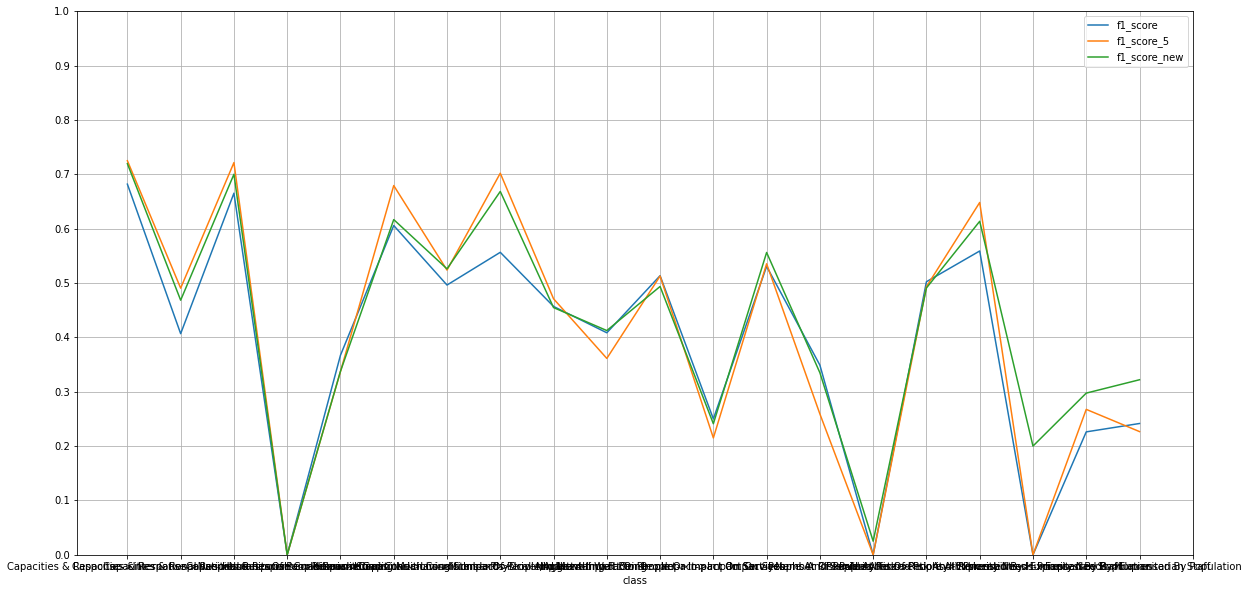

In [43]:
joined[['f1_score', 'f1_score_5', 'f1_score_new']].plot(figsize=(20, 10), xticks=range(len(SUBPILLARS)+1), yticks=[x/10 for x in range(11)], ylim=(0, 1), grid=True)

# Inspect results

In [76]:
resampled5_results.classes

['Capacities & Response',
 'Capacities & Response->International Response',
 'Capacities & Response->National Response',
 'Capacities & Response->Number Of People Reached',
 'Capacities & Response->Response Gaps',
 'Humanitarian Conditions',
 'Humanitarian Conditions->Coping Mechanisms',
 'Humanitarian Conditions->Living Standards',
 'Humanitarian Conditions->Number Of People In Need',
 'Humanitarian Conditions->Physical And Mental Well Being',
 'Impact',
 'Impact->Driver/Aggravating Factors',
 'Impact->Impact On People',
 'Impact->Impact On People Or Impact On Services',
 'Impact->Impact On Services',
 'Impact->Impact On Systems And Services',
 'Impact->Number Of People Affected',
 'People At Risk',
 'People At Risk->Number Of People At Risk',
 'People At Risk->Risk And Vulnerabilities',
 'Priority Interventions',
 'Priority Interventions->Expressed By Humanitarian Staff',
 'Priority Interventions->Expressed By Population',
 'Priority Needs',
 'Priority Needs->Expressed By Humanitaria

In [77]:
for i, x in enumerate(resampled5_results.test_targets[0]):
    if x:
        print(resampled5_results.classes[i])

Humanitarian Conditions
Humanitarian Conditions->Coping Mechanisms
Humanitarian Conditions->Living Standards
Humanitarian Conditions->Physical And Mental Well Being
People At Risk
People At Risk->Risk And Vulnerabilities


In [70]:
resampled5_results.test_preds

tensor([[3.3425e-03, 5.0780e-07, 7.9411e-06,  ..., 9.6688e-05, 1.3268e-09,
         3.6622e-09],
        [9.9735e-01, 9.9367e-01, 1.7090e-01,  ..., 7.5125e-08, 6.7299e-15,
         9.7276e-15],
        [1.7258e-03, 1.2547e-07, 1.0205e-05,  ..., 7.3872e-06, 9.4831e-11,
         3.2621e-13],
        ...,
        [1.3767e-01, 1.5621e-04, 1.3215e-02,  ..., 5.8271e-01, 1.3070e-02,
         3.3862e-01],
        [4.6626e-03, 6.0594e-07, 4.6855e-05,  ..., 7.4559e-06, 1.2523e-11,
         8.9302e-11],
        [8.8518e-01, 1.0324e-01, 6.8829e-01,  ..., 3.3534e-06, 2.3583e-11,
         1.9363e-11]])

In [96]:
classes = np.array(resampled5_results.classes)

In [106]:
for text, pred, target in zip(test_df.excerpt, resampled5_results.test_preds, resampled5_results.test_targets):
    print(text)
    print(sorted(classes[pred>0.15]))
    print(sorted(classes[target==1]))
    
    
    a = input()
    if a == 's':
        break

What this means is that families across the country can no longer afford the very basics. And food security and nutrition indicators clearly reflect that. Some 9.3 million people are food insecure. More than 2 million more are at risk of becoming food insecure. 86 per cent of households say they are buying lower quality food, or less food, or skipping meals.
['Humanitarian Conditions', 'Humanitarian Conditions->Coping Mechanisms', 'Humanitarian Conditions->Living Standards', 'Humanitarian Conditions->Physical And Mental Well Being', 'People At Risk', 'People At Risk->Risk And Vulnerabilities']
['Humanitarian Conditions', 'Humanitarian Conditions->Coping Mechanisms', 'Humanitarian Conditions->Living Standards', 'Humanitarian Conditions->Physical And Mental Well Being', 'People At Risk', 'People At Risk->Risk And Vulnerabilities']

Dispatch and Referral Unit (DRU): IOM continues to coordinate an expanded fleet of 22 vehicles, 11 of which are supplied by IOM and staffed with drivers fully

In [102]:
target

tensor([0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 0., 0.])

array(['Capacities & Response',
       'Capacities & Response->National Response',
       'Humanitarian Conditions', 'People At Risk'], dtype='<U55')